# Train Plain NODE on multi-k data from decay-generation

In [33]:
import torch 
import numpy as np


from torchode import solve_ivp
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

from data.budworm import simulate_trials, budworm_steady_states
from stabnode.utils import set_global_seed
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')



seed = 1234
set_global_seed(seed=seed)


device='cpu'
savefigs = False
folder = "figures_g_sigmoid/"

In [30]:
k_vals = [5.5, 8.5,11,7.5,6.3]
xs = np.linspace(0.1, 10, 51)

In [31]:
trials = {}


for idx, ki in enumerate(tqdm(k_vals)):

    ki_traj = []
    ki_times= []
    
    for x0 in tqdm(xs, leave=False):
        trial_ki = simulate_trials([ki],x0,dt=0.2,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501,show_progress=False)
        ti = trial_ki.t_vals[0]
        xi = trial_ki.x_vals[0]

        if len(ti) == 1:
            continue
        ki_traj.append(xi)
        ki_times.append(ti)

    trials[f"{idx}"] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki, 
        "trial": idx
    }

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

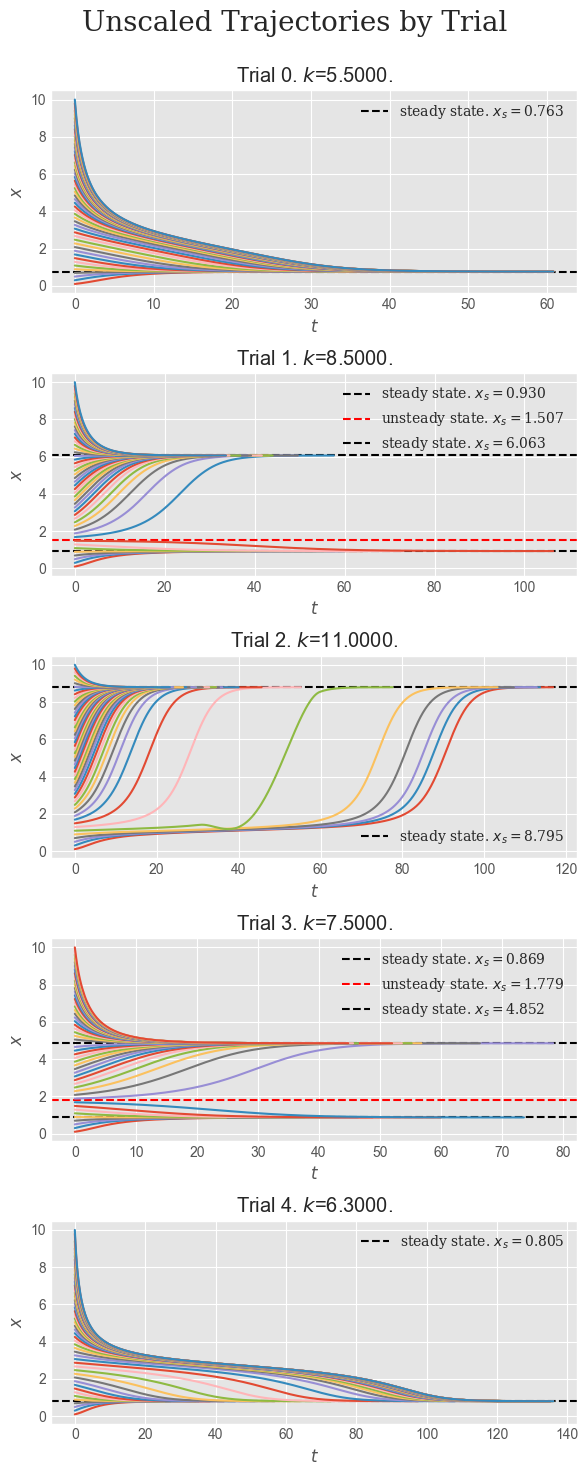

In [32]:
cols = 1
rows = len(trials)

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))

axs = axs.flatten()

for idx in range(rows):
    ax = axs[idx]
    trial_i = trials[f"{idx}"]

    times = trial_i["times"]
    traj = trial_i["traj"]
    ki = trial_i["k"]

    for ti, xi in zip(times, traj):
        ax.plot(ti,xi)

    for idx2,xsi in enumerate(budworm_steady_states(ki,r=0.56)):
        label = rf"steady state. $x_s=${xsi:.3f}"
        color = 'black'
        if idx2 ==1:
            label = rf"unsteady state. $x_s=${xsi:.3f}"
            color = 'red'

        ax.axhline(
            xsi,
            xmin=0,
            c=color,
            linestyle="--",
            label=label,
            zorder=1
        )
    
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
    ax.set_title(rf"Trial {idx}. $k$={ki:.4f}.")
    ax.legend(prop={'family':'serif'})




plt.suptitle("Unscaled Trajectories by Trial", family='serif',size=20)
plt.tight_layout(rect=[0,0,1,0.98])

if savefigs:
    file_name = f"unscaled_trajectories_num_k_{len(k_trials)}_num_x0_{len(xs)}.pdf"
    plt.savefig(folder+file_name)

plt.show()    


## Preprocess data

In [9]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [10]:
trial_df = pd.DataFrame(trials)

full_traj = []
for col in trial_df.columns:
    full_traj.append(np.concatenate(trial_df[col].traj))

scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1,1))

scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_traj = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in traj]
    scaled_rows[col] = scaled_traj

trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

all_xs = []
all_ts = []
all_ks = []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled]
    ts_torch = [torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in range(len(ts))]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)


In [11]:
from typing import List

class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials:List, t_trials:List, k_trials: List):
        self.x_trials = x_trials            
        self.t_trials = t_trials    
        self.k_trials = k_trials          

    def __len__(self):
        return len(self.x_trials) 

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        
        Xi = self.x_trials[idx]                                          
        ti = self.t_trials[idx]  
        x0 = Xi[0]           
        ki = self.k_trials[idx]

        return Xi,ti,x0, ki

In [12]:
cutoff = 1
train_dataset = TrialsDataset(all_xs[::cutoff],all_ts[::cutoff],all_ks[::cutoff])
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=1,num_workers=0)

In [13]:
train_dataset[0][-1]

tensor(5.5000)

In [20]:
import torch
import torch.nn as nn
from stabnode.node import MLP


class ODEFunc(nn.Module):
    def __init__(
        self,
        dims,          
        activation=nn.SiLU(),
        lower_bound=-1.0,
        upper_bound=1.0,
        dtype=torch.float
    ):
        super().__init__()
        self.dims = dims
        self.activation = activation
        self.dtype = dtype

        self.network = MLP(self.dims, activation=self.activation, dtype=self.dtype)

        self.args = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    def forward(self,x,k):
        """
        state = (x, k)
        x : [batch, dim_x]
        k : [batch, dim_k]
        """
        # x, k 
        a = self.args["lower_bound"]
        b = self.args["upper_bound"]

        xk = torch.cat([x, k], dim=-1)                 
        dxdt = a + (b - a) * torch.sigmoid(self.network(xk))  

        return dxdt


In [22]:
F = ODEFunc(
    dims=[2,10,10,1],
    activation=nn.SiLU(),
    lower_bound=0,
    upper_bound=1
)

In [23]:
*_, x0i, ki = train_dataset[9]

In [27]:
F(x0i.reshape(-1,1), ki.reshape(-1,1))

tensor([[0.4487]], grad_fn=<AddBackward0>)

In [ ]:
import copy
import torch
import torch.nn as nn


def _save_model_opt_cpu(model: ODEFunc, opt, epoch, loss, save_path: str, scheduler=None):
    device = next(model.parameters()).device.type
    
    # Move to CPU if necessary
    if device == "cpu":
        model_state = model.state_dict()
    else:
        model_cpu = copy.deepcopy(model).to("cpu")
        model_state = model_cpu.state_dict()

    # Save constructor args
    model_args = {
        "dims": model.dims,
        "activation": type(model.activation),  # store class, not instance
        "lower_bound": model.args["lower_bound"],
        "upper_bound": model.args["upper_bound"],
        "dtype": model.dtype,
    }

    checkpoint = {
        "model_state_dict": model_state,
        "model_args": model_args,
        "opt_state_dict": opt.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }

    if scheduler is not None:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()

    torch.save(checkpoint, save_path)


In [42]:
from typing import Callable, Optional, Tuple
from pathlib import Path
from stabnode.schedulers import ExpLossTimeDecayScheduler
from stabnode.node import _create_save_paths,_save_log_history
from stabnode.utils import _load_loop_wrapper
import time

def model_trainer(
        model: ODEFunc,
        opt: torch.optim.Optimizer,
        loss_criteria: Callable,
        train_loader: torch.utils.data.DataLoader,
        n_epochs: int,
        control: Callable[[torch.Tensor], torch.Tensor],
        min_improvement:float,
        patience: int,
        solve_method: str='tsit5', 
        save_folder: str|Path=None,
        show_progress:bool=True,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler]=None,
        print_every: int=5,
        _precision: int = 4,
        effective_batch_size: int = 10,
        train_dyn = True,
        decay_scheduler: Optional[ExpLossTimeDecayScheduler] = None,
        decay_val:int = 0.0
)-> Tuple[ODEFunc,dict]:
    """
    if decay_scheduler is given, this takes priority over decay_val.
    """
    
    loop_wrapper = _load_loop_wrapper(show_progress)
    model_opt_save_path, log_save_path = _create_save_paths(save_folder)

    best_loss = torch.inf
    patience_count = 0
    best_model_epoch = -1
    stopping_criteria = 'max-epochs'

    losses = []
    times = []
    status = []
    patience_hist = []
    lr_hist = []
    alpha_hist = []
    model.train()
    max_iters = len(train_loader)
     #this is training iteration counter to keep track of effective batch size.
    for epoch in loop_wrapper(range(n_epochs)):
        t1 = time.time()
        epoch_loss = 0.0
        num_batches = 0
        epochs_status = []
        iter_counter = 0
        for Xi, Ti, x0i, ki in train_loader:
            Xi = Xi.squeeze() # [batch, time, dim]
            Ti = Ti.squeeze()
            x0i = x0i.view(-1,1)

            if not x0i.requires_grad:
                x0i = x0i.clone().detach().requires_grad_()

            control = lambda t: ki

            opt.zero_grad()

            def rhs(t,x):
                return model(x,ki.view(-1,1))

            if train_dyn == True:
                sol = solve_ivp(
                    f=rhs,
                    y0=x0i,
                    t_eval=Ti,
                    method=solve_method
                )

                epochs_status.append(sol.status)

                if decay_scheduler is not None:
                    decay_val = decay_scheduler.get_alpha() 

                Xi_pred = sol.ys.squeeze()
                loss = loss_criteria(
                    Xi_pred*torch.exp(-decay_val*Ti), 
                    Xi*torch.exp(-decay_val*Ti)
                )

            Xi = Xi.unsqueeze(-1)
            cntrl = control(Ti)
            cntrl = torch.reshape(cntrl,(1,1))
            cntrl = cntrl.repeat(Xi.shape[0],1)
            g_id_loss = 100*loss_criteria(model(Xi,cntrl),Xi)

            if train_dyn == True:
                #loss = loss +  g_id_loss
                loss = loss
            else:
                loss = g_id_loss

            loss.backward()

            iter_counter += 1
            if effective_batch_size>= 1:
                if (iter_counter+1)%effective_batch_size==0 or iter_counter>= max_iters:
                    opt.step()
                    opt.zero_grad()
                    num_batches += 1
            else:
                opt.step()
                opt.zero_grad()
                num_batches += 1

            epoch_loss+= loss.item()
        epoch_loss = epoch_loss / num_batches

        if decay_scheduler is not None:
            decay_scheduler.step(epoch_loss)

            if decay_scheduler.get_alpha() == 0.0 and scheduler is not None:
                scheduler.step(epoch_loss)
                
        elif scheduler is not None:
            scheduler.step(epoch_loss)
     
        cur_lr = opt.param_groups[0]['lr']
        cur_alpha = decay_scheduler.get_alpha() if decay_scheduler is not None else decay_val

        epoch_time = time.time() - t1

        losses.append(epoch_loss)
        times.append(epoch_time)
        status.append(epochs_status)
        lr_hist.append(cur_lr)

        if show_progress:
            if epoch <= 5 or epoch % print_every == 0 or epoch == n_epochs-1:
                print(f"Epoch {epoch}: Loss: {epoch_loss:.{_precision}f}. time = {epoch_time:.{_precision}f}s. lr = {cur_lr:.{_precision}f}. alpha = {cur_alpha:.{_precision}f}")    
        
        # model checks
        if best_loss - epoch_loss >= min_improvement:
            best_loss = epoch_loss
            patience_count = 0
            best_model_epoch = epoch

            if save_folder is not None:
                _save_model_opt_cpu(
                    model,
                    opt,
                    best_model_epoch,
                    best_loss,
                    model_opt_save_path,
                    scheduler
                )

        else:
            patience_count += 1
        
        patience_hist.append(patience_count)

        if patience_count > patience:
            stopping_criteria = 'early-stoppage'
            if show_progress is not None:
                print(f"Patience exceeded: {patience}. Early stoppage executed.")
            break
        
        if save_folder is not None:
            _ = _save_log_history(
                losses,
                times,
                stopping_criteria=f"checkpoint-{epoch}",
                best_model_epoch=best_model_epoch,
                method_status=status,
                patience_hist=patience_hist,
                lr_hist=lr_hist,
                save_path = log_save_path
            )
        
    log_history = _save_log_history(
        losses,
        times,
        stopping_criteria,
        best_model_epoch,
        status,
        patience_hist,
        lr_hist,
        log_save_path,
    )

    return model, log_history

In [43]:
n_epochs = 1000
lr = 1e-2
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(F.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)

model, log_history = model_trainer(
    model=F,
    opt=opt,
    loss_criteria=loss_criteria,
    train_loader=train_loader,
    n_epochs=n_epochs,
    control=None,
    min_improvement=1e-6,
    patience=300,
    solve_method='tsit5',
    save_folder=None,
    show_progress=True,
    scheduler=scheduler,
    print_every=10,
    _precision=10,
    train_dyn = True,
    effective_batch_size=10,
    decay_scheduler=None,
    decay_val=0.8
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss: 0.0039047355. time = 29.5887899399s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 1: Loss: 0.0005145509. time = 19.1407837868s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 2: Loss: 0.0005052817. time = 16.9788579941s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 3: Loss: 0.0005024728. time = 16.9377079010s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 4: Loss: 0.0005003156. time = 16.1713500023s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 5: Loss: 0.0004978379. time = 15.1374719143s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 10: Loss: 0.0004951169. time = 14.0207297802s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 20: Loss: 0.0004935250. time = 11.4050099850s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 30: Loss: 0.0004931676. time = 10.7754650116s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 40: Loss: 0.0004930079. time = 10.2214217186s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 50: Loss: 0.0004929476. time = 9.6607339382s. lr = 0.0100000000. alpha

KeyboardInterrupt: 